## MLP-based Values prediction 

### 1. Install required dependency libraries

In [1]:
"""
Install required dependency libraries
-pip install pandas
-pip install scikit-learn
-pip install tensorflow
-import matplotlib.pyplot as plt

"""

'\nInstall required dependency libraries\n-pip install pandas\n-pip install scikit-learn\n-pip install tensorflow\n-import matplotlib.pyplot as plt\n\n'

### 2. Import installed required dependency libraries

In [2]:
# Import required libraries for LSTM model
import os
#import gdown # Colab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 3. Prepare the datset

#### Shareable linke: https://drive.google.com/file/d/1BLc-MzpYVGGxlzl42rDsU90Lhi6TZPVZ/view?usp=share_link

In [3]:
# Use for colab
#!gdown --id 1BLc-MzpYVGGxlzl42rDsU90Lhi6TZPVZ

In [4]:
# Load the CSV file into a pandas dataframe
dataframe = pd.read_csv("dataset.csv")

In [5]:
#To see the whole inforamtion contenet of the above dataset:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248776 entries, 0 to 248775
Data columns (total 94 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   index                      248776 non-null  int64  
 1   open                       248776 non-null  float64
 2   high                       248776 non-null  float64
 3   close                      248776 non-null  float64
 4   low                        248776 non-null  float64
 5   timestamp                  248776 non-null  int64  
 6   transactions               248776 non-null  int64  
 7   volume                     248776 non-null  int64  
 8   volume_adi                 248776 non-null  float64
 9   volume_obv                 248776 non-null  int64  
 10  volume_cmf                 248776 non-null  float64
 11  volume_fi                  248776 non-null  float64
 12  volume_em                  248776 non-null  float64
 13  volume_sma_em              24

In [6]:
# To see the first five data content of the above dataset:
dataframe.head()

,index,open,high,close,low,timestamp,transactions,volume,volume_adi,volume_obv,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,0,1.30785,1.30805,1.30802,1.30776,1367884800000,471,471,373.551724,471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.308020,12.794800,0.000000,0.000000
1,1,1.30803,1.30840,1.30830,1.30785,1367885700000,561,561,730.551724,1032,...,0.001708,0.000342,0.001366,1.503033,0.300607,1.202426,1.308143,0.021406,0.021404,0.021406
2,2,1.30830,1.30884,1.30781,1.30780,1367886600000,2309,2309,-1534.044430,-1277,...,0.000038,0.000281,-0.000243,24.809883,5.202462,19.607421,1.307998,-0.037453,-0.037460,-0.016055
3,3,1.30781,1.30836,1.30810,1.30771,1367887500000,1909,1909,-1152.244430,632,...,0.000498,0.000324,0.000173,32.724413,10.706852,22.017561,1.308042,0.022174,0.022172,0.006116
4,4,1.30809,1.30833,1.30819,1.30791,1367888400000,926,926,-843.577763,1558,...,0.001401,0.000539,0.000862,29.460350,14.457552,15.002799,1.308107,0.006880,0.006880,0.012997


In [7]:
# Drop the rows containing NaN values
dataframe = dataframe.dropna()

In [8]:
# select the relevant features for prediction
features = ['open', 'high', 'close', 'low']

In [9]:
# normalize the data
scaler = MinMaxScaler()
scaled_dataframe = scaler.fit_transform(dataframe[features])

In [10]:
# split the data into training and testing sets
train_size = int(len(scaled_dataframe) * 0.8)
train_data = scaled_dataframe[:train_size, :]
test_data = scaled_dataframe[train_size:, :]

In [11]:
# define the training and testing datasets
def create_dataset(data, window_size=1):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

In [12]:
window_size = 60
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

### 4. Define and build the LSTM-model

In [13]:
# Add an LSTM layer with 50 units and input shape of (60, 4)
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 4)))
# Add dropout layer
model.add(Dropout(0.2))
# Add another LSTM layer with 50 units
model.add(LSTM(50, return_sequences=True))
# Add another dropout layer
model.add(Dropout(0.2))
# Add another LSTM layer 
model.add(LSTM(50))
# Add a fully connected dense layer with 4 units
model.add(Dense(4))

In [14]:
# Print-out the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11000     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 51,604
Trainable params: 51,604
Non-traina

In [15]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [16]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

### 5. Train the LSTM-model

In [17]:
# train the model
#model.fit(X_train, y_train, epochs=10, batch_size=32)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
6218/6218 [==============================] - 723s 115ms/step - loss: 2.9849e-04 - accuracy: 0.5961 - val_loss: 1.8534e-05 - val_accuracy: 0.7186
Epoch 2/20
6218/6218 [==============================] - 632s 102ms/step - loss: 4.3296e-05 - accuracy: 0.7886 - val_loss: 5.8496e-05 - val_accuracy: 0.7294
Epoch 3/20
6218/6218 [==============================] - 687s 110ms/step - loss: 3.0756e-05 - accuracy: 0.8550 - val_loss: 2.9459e-05 - val_accuracy: 0.7491
Epoch 4/20
6218/6218 [==============================] - 663s 107ms/step - loss: 2.5562e-05 - accuracy: 0.8943 - val_loss: 1.5508e-05 - val_accuracy: 0.7491
Epoch 5/20
6218/6218 [==============================] - 557s 90ms/step - loss: 2.2206e-05 - accuracy: 0.9018 - val_loss: 2.9854e-04 - val_accuracy: 0.7363
Epoch 6/20
6218/6218 [==============================] - 593s 95ms/step - loss: 1.9834e-05 - accuracy: 0.8981 - val_loss: 2.6046e-05 - val_accuracy: 0.7440
Epoch 7/20
6218/6218 [==============================] - 633s 102ms

### 6. Plot the training

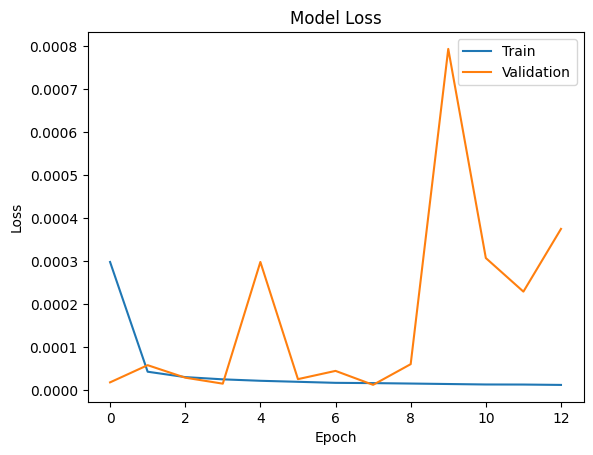

In [26]:
# plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

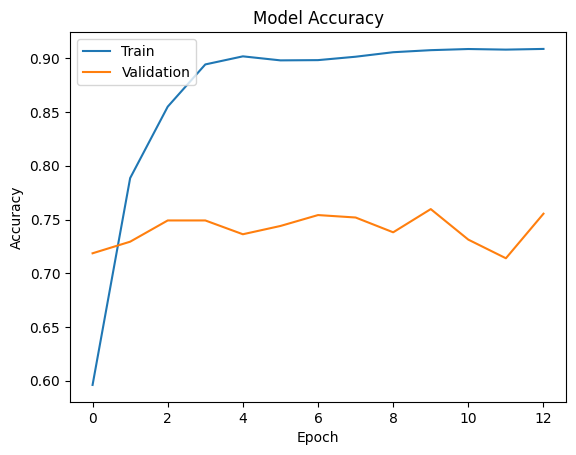

In [27]:
# plot the training and validation accuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 7. Evaluate the trained model

In [32]:
# evaluate the model on the testing data
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

1553/1553 [==============================] - 60s 39ms/step


In [33]:
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.3201847810045241
Mean Absolute Error: 0.5628687165325449
R-squared: -9817.818338715286


### 8. Testing

In [34]:
# make predictions on new data
new_data = np.array([scaled_dataframe[-window_size:, :]])
predictions = model.predict(new_data)
predictions = scaler.inverse_transform(predictions)
predicted_open, predicted_high, predicted_close, predicted_low = predictions[0]
print(f'Predicted open: {predicted_open}')
print(f'Predicted high: {predicted_high}')
print(f'Predicted close: {predicted_close}')
print(f'Predicted low: {predicted_low}')

1/1 [==============================] - 0s 92ms/step
Predicted open: 1.1017491817474365
Predicted high: 1.1022394895553589
Predicted close: 1.1018675565719604
Predicted low: 1.101608395576477


### 9. Save the model

In [23]:
# Save the model
model.save("lstm_new_model.h5")

In [24]:
# save the scaler parameters
np.save('scaler_params.npy', scaler.get_params())

### 10. Predict values

In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

# Load the saved model
model = load_model('lstm_new_model.h5')

# Load and preprocess the test dataset
test_data = pd.read_csv('test.csv')
test_data.drop('timestamp', axis=1, inplace=True)  # Exclude timestamp column

# Normalize the data using a scaler
scaler = MinMaxScaler()
scaler.fit(test_data)

# Apply scaling to the test data
scaled_data = scaler.transform(test_data)

# Define the window size
window_size = 60

# Prepare the input data for prediction
input_data = []
for i in range(window_size, len(scaled_data)):
    input_data.append(scaled_data[i - window_size:i, :])

# Convert the input data to a numpy array
input_data = np.array(input_data)

# Make predictions using the model
predicted_prices = model.predict(input_data)

# Denormalize the predictions using the scaler
predicted_prices = scaler.inverse_transform(predicted_prices)

# Extract the predicted values for the next 15 minutes
next_15_min_predictions = predicted_prices[-15:]

# Access the individual open, close, low, and high values
open_price = next_15_min_predictions[:, 0]
close_price = next_15_min_predictions[:, 1]
low_price = next_15_min_predictions[:, 2]
high_price = next_15_min_predictions[:, 3]

# Print the predicted prices
for i in range(15):
    print(f"Prediction {i+1}:")
    print(f"Open Price: {open_price[i]:.2f}")
    print(f"Close Price: {close_price[i]:.2f}")
    print(f"Low Price: {low_price[i]:.2f}")
    print(f"High Price: {high_price[i]:.2f}")
    print()


d:\AI\Value_prediction\value_pred\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
d:\AI\Value_prediction\value_pred\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


ValueError: in user code:

    File "d:\AI\Value_prediction\value_pred\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "d:\AI\Value_prediction\value_pred\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\AI\Value_prediction\value_pred\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "d:\AI\Value_prediction\value_pred\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "d:\AI\Value_prediction\value_pred\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\AI\Value_prediction\value_pred\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 60, 4), found shape=(None, 60, 95)
